<a href="https://colab.research.google.com/github/yashpatel5400/schrodinger_op/blob/main/schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/yashpatel5400/schrodinger_op
import sys
sys.path.append("schrodinger_op")
import numpy as np
from scipy.stats import ttest_rel
import constants
from estimator import LinearEstimator, random_low_order_state
from potentials import free_particle_potential, harmonic_oscillator_potential, barrier_potential
from time_dep import split_step_solver_2d
from matplotlib import pyplot as plt

Cloning into 'schrodinger_op'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 43 (delta 17), reused 36 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 22.27 KiB | 5.57 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
from scipy.fft import ifftn
from scipy.fft import fftn

def GRF(alpha, beta, gamma, N):
    # Random variables in KL expansion
    xi = np.random.randn(N, N)

    K1, K2 = np.meshgrid(np.arange(N), np.arange(N))

    # Define the (square root of) eigenvalues of the covariance operator
    coef = alpha**(1/2) *(4*np.pi**2 * (K1**2 + K2**2) + beta)**(-gamma / 2)
    #coef = alpha**(1/2) *((K1**2 + K2**2) + beta)**(-gamma / 2)

    # Construct the KL coefficients
    L = N * coef * xi

    #to make sure that the random field is mean 0
    L[0, 0] = 0

    return ifftn(L, norm='forward')

In [ ]:
N = 64
L = 2*np.pi
dx = L/N
T = 0.2
num_steps = 100
K = 16
potential = "barrier"
V_grids = {
        "free": free_particle_potential(N),
        "harmonic_oscillator": harmonic_oscillator_potential(N, L, omega=2.0, m=constants.m),
        "barrier": barrier_potential(N, L, barrier_height=50.0, slit_width=0.2),
    }
V_grid = V_grids[potential]
estimator = LinearEstimator(V_grid, N, dx, T, num_steps, K)

In [ ]:
num_test = 100
#test_samples = [random_low_order_state(N, K=K) for _ in range(num_test)]
test_samples = [GRF(1, 1, 3, N) for _ in range(num_test)]
test_samples = [psi / np.linalg.norm(psi) for psi in test_samples]


In [ ]:
lin_est_errors = []
for psi0 in test_samples:
      psi_true = split_step_solver_2d(V_grid, psi0, N, dx, T, num_steps)
      psi_lin = estimator.compute_estimate(psi0)
      err_lin_num = np.linalg.norm(psi_lin - psi_true)
      err_lin_den = np.linalg.norm(psi_true) + 1e-14
      rel_lin_err = err_lin_num / err_lin_den
      lin_est_errors.append(rel_lin_err)
print("Mean Test Error: ", np.mean(lin_est_errors))
print("Max Test Error: ", np.max(lin_est_errors))

Mean Test Error:  0.0018559873306040506
Max Test Error:  0.006956668755042123


# Visualization

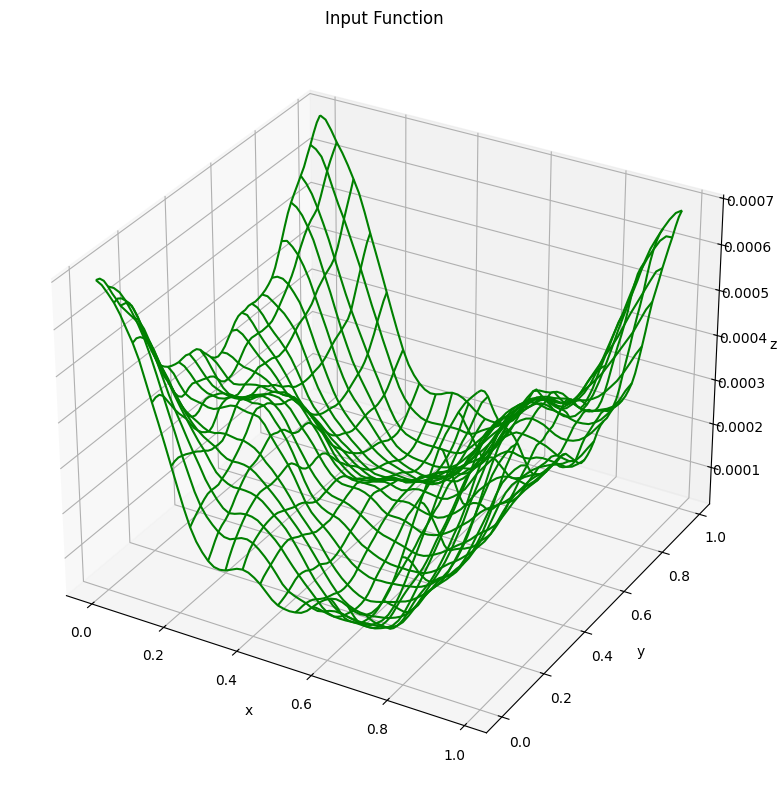

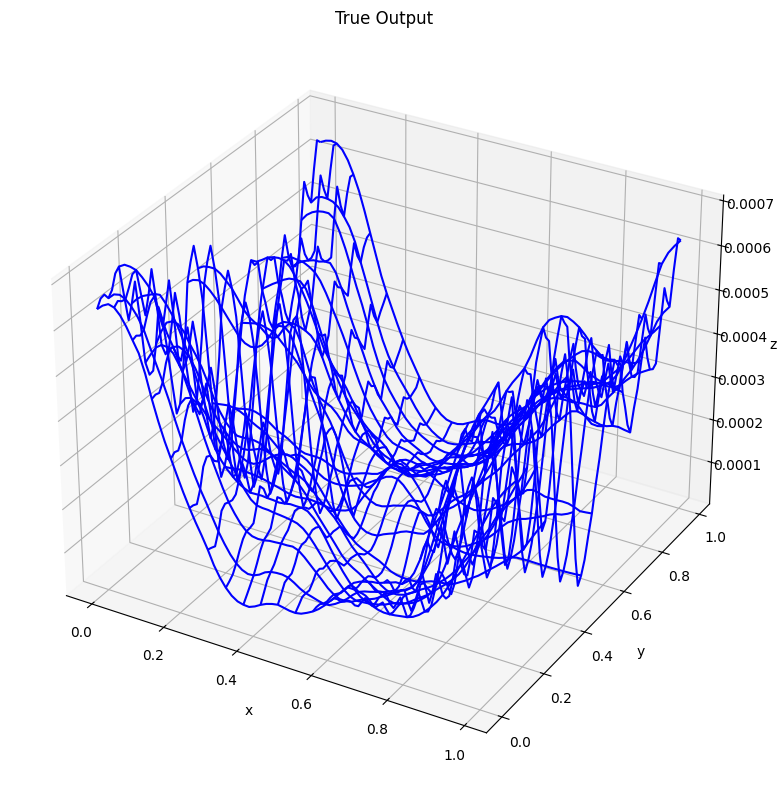

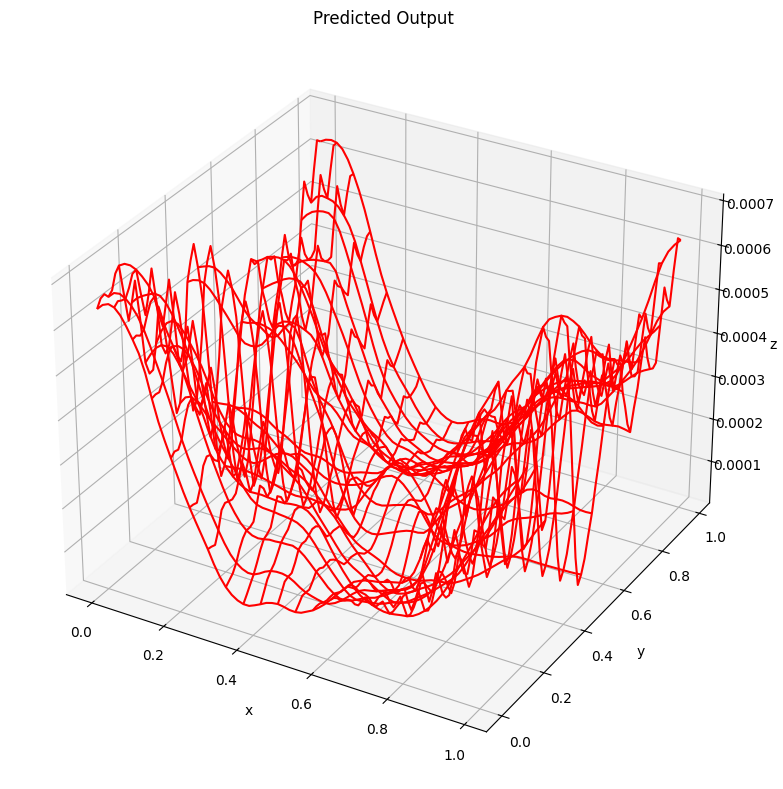

In [ ]:
import random


random_index = random.randint(0, len(test_samples) - 1)
input = test_samples[random_index]

output_actual=split_step_solver_2d(V_grid, input, N, dx, T, num_steps)
output_pred = estimator.compute_estimate(input)

x = np.arange(0,1, 1/N)
y = np.arange(0,1, 1/N)
X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(X, Y, np.abs(input)**2, color='g', rstride=3, cstride=3, label='Input Actual')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("Input Function")
plt.tight_layout()
#plt.savefig('input.png', dpi=300)


# Plot the actual output as a wireframe
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_wireframe(X, Y, np.abs(output_actual)**2, color='b', rstride=3, cstride=3, label='Actual')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("True Output")
plt.tight_layout()
#plt.savefig('actual.png', dpi=300)

# Plot the predicted output as a wireframe
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_wireframe(X, Y, np.abs(output_pred)**2, color='r', rstride=3, cstride=3, label='Predicted')
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
ax3.set_title("Predicted Output")
plt.tight_layout()
#plt.savefig('predicted.png', dpi=300)

#Plot the input actual

plt.tight_layout()
plt.show()




# Convergence Rates

In [ ]:
def fourier(N, k1, k2):
    # Initialize an N x N array with zeros in the frequency domain
    init_array = np.zeros((N, N))
    # Set the appropriate frequency component to 1 (place "spike" at (k1, k2))
    init_array[k1,k2] = 1

    # Perform the inverse FFT to obtain the spatial cosine pattern
    return ifftn(init_array, norm='forward')


trainset = []
for k1 in range(0,K):
  for k2 in range(0,K):
    psi0 = fourier(N, k1, k2)
    psiT = split_step_solver_2d(V_grid, psi0.copy(), N, dx, T, num_steps)
    trainset.append({'x': psi0,'y': psiT})

In [ ]:
num_test = 100
#test_samples = [random_low_order_state(N, K=K) for _ in range(num_test)]
test_samples = [GRF(1, 1, 2, N) for _ in range(num_test)]
test_samples = [psi / np.linalg.norm(psi) for psi in test_samples]

[9.99394784e+13 6.03968377e+00 2.40042203e+00 2.12301182e+00
 2.08110155e+00 2.06717639e+00 2.04405674e+00 2.03327507e+00
 2.03102852e+00 2.02979480e+00 2.02715963e+00 2.02597088e+00
 2.02543701e+00 2.02494762e+00 2.02455458e+00 2.02400188e+00
 6.48851182e-01 4.21298237e-01 3.74247383e-01 3.62234314e-01
 3.57831291e-01 3.55969954e-01 3.55013198e-01 3.54421495e-01
 3.54005513e-01 3.53779077e-01 3.53664209e-01 3.53584469e-01
 3.53515010e-01 3.53456504e-01 3.53420656e-01 3.53391408e-01
 2.90716716e-01 2.50328141e-01 2.30380238e-01 2.21034884e-01
 2.16806035e-01 2.15112965e-01 2.13707378e-01 2.12927225e-01
 2.12596983e-01 2.12328853e-01 2.12154344e-01 2.12032038e-01
 2.11938013e-01 2.11885570e-01 2.11833185e-01 2.11801617e-01
 1.85914352e-01 1.70389759e-01 1.60902043e-01 1.53834487e-01
 1.50525358e-01 1.48599004e-01 1.47621712e-01 1.47032561e-01
 1.46654621e-01 1.46382123e-01 1.46215957e-01 1.46089446e-01
 1.45988127e-01 1.45919347e-01 1.45876108e-01 1.45825231e-01
 1.36723959e-01 1.306398

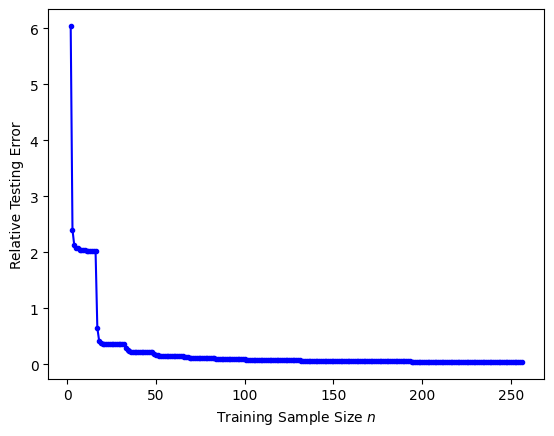

In [ ]:
losses = []

for psi0 in test_samples:
    psi_true = split_step_solver_2d(V_grid, psi0.copy(), N, dx, T, num_steps)
    psi_pred = psi0.copy()*0
    scores = fftn(psi0, norm='forward')[:K, :K].flatten()
    loss_per_sample = []
    for j in range(len(trainset)):
        psi_pred = psi_pred +  trainset[j]['y'] * scores[j]
        err_lin_num = np.linalg.norm(psi_pred - psi_true)
        err_lin_den = np.linalg.norm(psi_pred) + 1e-14
        rel_lin_err = err_lin_num / err_lin_den
        loss_per_sample.append(rel_lin_err)
    losses.append(loss_per_sample)


linear_losses = np.mean(losses, axis=0)
print(linear_losses)
plt.plot(range(2, len(linear_losses)+1),linear_losses[1:], color='blue', marker='o', markersize=3, linestyle='-')
plt.xlabel('Training Sample Size $n$')
plt.ylabel('Relative Testing Error')
plt.savefig("error.png")
plt.show()

[9.99394784e+13 6.03968377e+00 2.40042203e+00 2.12301182e+00
 2.08110155e+00 2.06717639e+00 2.04405674e+00 2.03327507e+00
 2.03102852e+00 2.02979480e+00 2.02715963e+00 2.02597088e+00
 2.02543701e+00 2.02494762e+00 2.02455458e+00 2.02400188e+00
 6.48851182e-01 4.21298237e-01 3.74247383e-01 3.62234314e-01
 3.57831291e-01 3.55969954e-01 3.55013198e-01 3.54421495e-01
 3.54005513e-01 3.53779077e-01 3.53664209e-01 3.53584469e-01
 3.53515010e-01 3.53456504e-01 3.53420656e-01 3.53391408e-01
 2.90716716e-01 2.50328141e-01 2.30380238e-01 2.21034884e-01
 2.16806035e-01 2.15112965e-01 2.13707378e-01 2.12927225e-01
 2.12596983e-01 2.12328853e-01 2.12154344e-01 2.12032038e-01
 2.11938013e-01 2.11885570e-01 2.11833185e-01 2.11801617e-01
 1.85914352e-01 1.70389759e-01 1.60902043e-01 1.53834487e-01
 1.50525358e-01 1.48599004e-01 1.47621712e-01 1.47032561e-01
 1.46654621e-01 1.46382123e-01 1.46215957e-01 1.46089446e-01
 1.45988127e-01 1.45919347e-01 1.45876108e-01 1.45825231e-01
 1.36723959e-01 1.306398

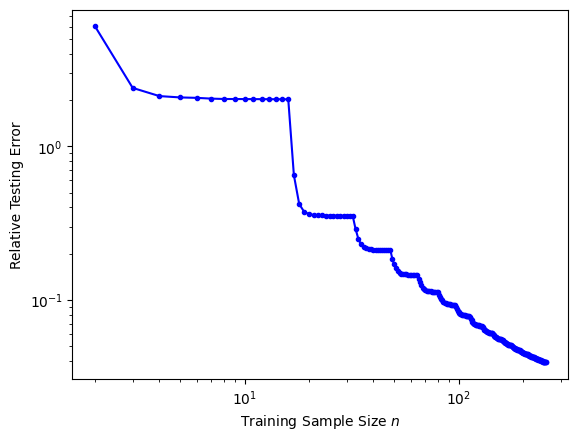

In [ ]:
linear_losses = np.mean(losses, axis=0)
print(linear_losses)
plt.loglog(range(2, len(linear_losses)+1),linear_losses[1:], color='blue', marker='o', markersize=3, linestyle='-')
plt.xlabel('Training Sample Size $n$')
plt.ylabel('Relative Testing Error')
plt.savefig("error.png")
plt.show()

# Time Generalization

In [ ]:
estimator = LinearEstimator(V_grid, N, dx, T, num_steps, K)


[0.03771053 0.04236826 0.04178429 0.04183589 0.04191194 0.04140231
 0.0417299  0.04208317 0.04162526 0.04177883 0.04173548 0.04187977
 0.04190672 0.04156794 0.04206061 0.04234473 0.04173515 0.04167196
 0.04219766 0.04185567 0.0426984  0.04171804 0.04161514 0.04160975
 0.04164057 0.04161202 0.04221022 0.04174342 0.04166065 0.0416835 ]


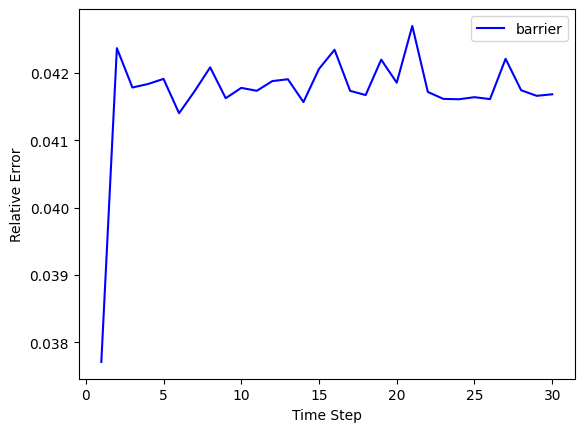

In [ ]:
m=30 # number of time steps
time_gen = []
for psi0 in test_samples[:50]:
    lin_est_errors = []
    for j in range(m):
        psi_true = split_step_solver_2d(V_grid, psi0, N, dx, T, num_steps)
        psi_lin = estimator.compute_estimate(psi0)
        err_lin_num = np.linalg.norm(psi_lin - psi_true)
        err_lin_den = np.linalg.norm(psi_true) + 1e-14
        rel_lin_err = err_lin_num / err_lin_den
        lin_est_errors.append(rel_lin_err)
        psi0 = psi_true

    time_gen.append(lin_est_errors)

errors=np.mean(time_gen, axis=0)
print(errors)
plt.plot(range(1,m+1), errors, color = "blue", label = potential)
plt.xlabel("Time Step")
plt.ylabel("Relative Error")
plt.legend()
plt.show()